In [65]:
import numpy as np
import pandas as pd

In [66]:
from Function_readLabChartMat import get_pages_data, backRMS, autoEventDetection, manualEventDetect, avgVals

In [67]:
# generating inputs and creating the path
import os
cmnPath = r'R:\Prosjekter\ELECTROPHYSIOLOGY_PD_1000214'
ptID = 'EHC06'

if ptID.startswith('EHC'):
    grp = 'HealthyControl'
elif ptID.startswith('EPD'):
    grp ='ParkinsonsDisease'


In [68]:
# creating path based on the inputs and changing the working director
filePath = os.path.join(cmnPath,grp,ptID)
os.chdir(filePath)

# locating the excel file 
xlFile = [f for f in os.listdir() if f.endswith('.xlsx') and f.startswith(ptID)]
print(xlFile)

xlPath = os.path.join(filePath,xlFile[0])
print(xlPath)


['EHC06_Visit Log_v01_24042024_Analysis.xlsx']
R:\Prosjekter\ELECTROPHYSIOLOGY_PD_1000214\HealthyControl\EHC06\EHC06_Visit Log_v01_24042024_Analysis.xlsx


In [69]:
# importing data from excel file
#READING EXCEL FILE
    
xlData = pd.ExcelFile(xlPath)     
xlDF = pd.read_excel(xlData,sheet_name="H-reflex")
 

In [70]:
# this is how  you can access to specific sheet of excel 
    # so, reading the entire excel sheet first and storing its information will be more efficient
# Display the indices (as a list of (row, column) tuples)

fileName_HMCurve = xlDF.iloc[13,1]
fileName_HMCurve = fileName_HMCurve + ".mat"
print(fileName_HMCurve)
fileName_shortTrials = xlDF.iloc[19,1]
fileName_shortTrials = fileName_shortTrials + ".mat"
print(fileName_shortTrials)
fileName_longTrials = xlDF.iloc[24,1]
fileName_longTrials = fileName_longTrials + ".mat"
print(fileName_longTrials)


EHC06_HMCurve_5trials_11062024.mat
EHC06_ShortTrial_15trials_11062024.mat
EHC06_LongTrial_40trials_11062024.mat


In [71]:
filename = os.path.join(filePath,fileName_shortTrials)
preTrigger = 50 #time in msec
postTrigger = 100 #time in msec
samp_rate = 4000
pre_time_ms = 50 
post_time_ms = 100
avgFact = 15

In [72]:
# calling function to obtain the pages
pages = get_pages_data(filename, samp_rate, pre_time_ms, post_time_ms, avgFact)
len(pages[0])


9

Text(0.5, 0, 'Time(ms)')

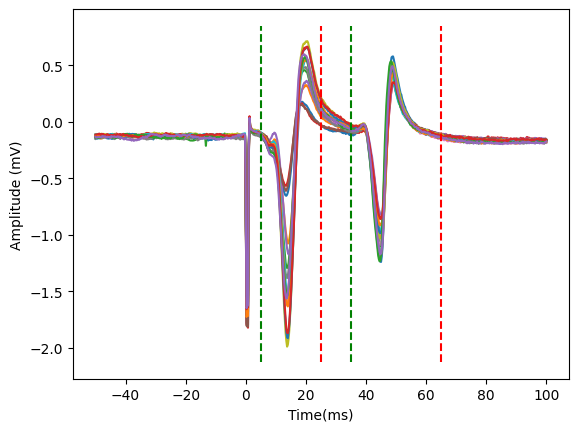

In [73]:
chNo = 1
import matplotlib.pyplot as plt

timeAxis = np.linspace(-pre_time_ms,post_time_ms,len(pages[0][0]))

hOnset_ms = 35
mOnset_ms = 5
hrangeTime_ms = 30
mrangeTime_ms = 20

for pg in range(len(pages)): 
    plt.plot(timeAxis,(pages[pg][chNo-1]*1000))
ymin, ymax = plt.ylim()
plt.vlines(x=[hOnset_ms, mOnset_ms], ymin=ymin, ymax=ymax, colors='green', linestyles='dashed', label='vlines')
plt.vlines(x=[hOnset_ms+hrangeTime_ms, mOnset_ms+mrangeTime_ms], ymin=ymin, ymax=ymax, colors='r', linestyles='dashed', label='vlines')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time(ms)")


In [74]:
HAmplitudes_mV = []
MAmplitudes_mV = []
for pgNo in range(len(pages)):
    indEpoch = pages[pgNo][chNo-1]
    hmSignal = manualEventDetect(indEpoch, pre_time_ms, samp_rate, hOnset_ms, mOnset_ms, hrangeTime_ms,mrangeTime_ms)
    hAmp = round((max(hmSignal[0]) - min(hmSignal[0]))*1000,3)
    HAmplitudes_mV.append(hAmp)
    mAmp = round((max(hmSignal[1]) - min(hmSignal[1]))*1000,3)
    MAmplitudes_mV.append(mAmp)

In [75]:
# extracting backRMS values and preparing it by average of certain values
RMS_Signal_StartTime_ms = 50
RMS_Signal_EndTime_ms = 1
RMS_samp_rate = samp_rate
RMS_pre_time_ms = pre_time_ms

RMS_signalArray = []
Pages_backrms = get_pages_data(filename, samp_rate, pre_time_ms, post_time_ms, avgFact = 1)
BackgroundRMS_mv = []
for pgNo_rms in range(len(Pages_backrms)):
    indEpoch_rms = Pages_backrms[pgNo_rms][chNo-1]
    RMS_signal = backRMS(indEpoch_rms, RMS_Signal_StartTime_ms, RMS_Signal_EndTime_ms, RMS_samp_rate, RMS_pre_time_ms)
    # removing DC offset
    RMS_noDCOffset = RMS_signal - np.mean(RMS_signal)
    RMS_signalArray.append(RMS_noDCOffset)
    rmsVal = round(np.sqrt(np.mean(RMS_noDCOffset**2))*1000,3)
    BackgroundRMS_mv.append(rmsVal)

# averaging by avgFact
avgBackgroundRMS_mV = avgVals(BackgroundRMS_mv, avgFact)
avgBackgroundRMS_mV = [round(num,3) for num in avgBackgroundRMS_mV]

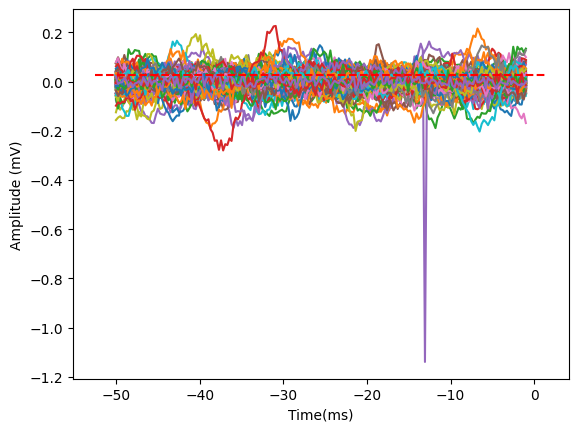

In [76]:
# Plotting the background RMS
RMS_timeax = np.linspace(-RMS_Signal_StartTime_ms, -RMS_Signal_EndTime_ms, len(RMS_signalArray[0]))

for RMS_no in range(len(RMS_signalArray)):
    plt.plot(RMS_timeax, RMS_signalArray[RMS_no]*1000)
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time(ms)")
xmin, xmax = plt.xlim()

plt.hlines(y=np.average(avgBackgroundRMS_mV), xmin=xmin, xmax=xmax, color='red', linestyle='--', label='y = 0.5')


In [77]:
# creating a df to be exported as excel file
partiID =  [ptID] * len(HAmplitudes_mV)
group = [grp] * len(HAmplitudes_mV)
trialOrder = list(range(1,len(HAmplitudes_mV)+1))
dict_outcome = {"ParticipantID": partiID, "Group": grp, "TrialOrder": trialOrder,"HAmplitudes_mV": HAmplitudes_mV, "MAmplitudes_mV": MAmplitudes_mV, "avgBackgroundRMS_mV":avgBackgroundRMS_mV}
df_output = pd.DataFrame(dict_outcome)

In [78]:
# reading conditions from XL
df_frmXL = pd.read_excel(xlData,sheet_name="Standing (ShortTrials)", usecols="B", skiprows=8, nrows=15)
trialOrder = list(range(1,len(df_frmXL)+1))
EOpen = df_frmXL['Condition (randomized order)'].str.contains('Open', case=False, na=False)
SurfaceFirm = df_frmXL['Condition (randomized order)'].str.contains('Firm', case=False, na=False)
DualTask = df_frmXL['Condition (randomized order)'].str.contains('DT', case=False, na=False)

#creating complexity
complexity_mapping = {
    'Eyes Open Firm': 1,
    'Eyes Open Foam': 2,
    'Eyes Closed Firm': 3,
    'Eyes Closed Foam': 4,
    'Eyes Closed Foam DT': 5
}

# Create the 'complexity' column by mapping the values in the existing column
Complexity = df_frmXL['Condition (randomized order)'].map(complexity_mapping) 

dict_forXL = {"ParticipantID": partiID, "TrialOrder": trialOrder,
              "EOpen": EOpen.astype(int), "SFirm":SurfaceFirm.astype(int), "DTask": DualTask.astype(int), "Complexity": Complexity.astype(int)}
df_XLCombined = df_frmXL.assign(**dict_forXL)


In [79]:
merged_df = pd.merge(df_XLCombined,df_output, on=['ParticipantID', 'TrialOrder'])
merged_df['Timestamp'] = pd.Timestamp('now').floor('s')
print(merged_df)


   Condition (randomized order) ParticipantID  TrialOrder  EOpen  SFirm  \
0                Eyes Open Firm         EHC06           1      1      1   
1                Eyes Open Firm         EHC06           2      1      1   
2                Eyes Open Firm         EHC06           3      1      1   
3              Eyes Closed Firm         EHC06           4      0      1   
4              Eyes Closed Firm         EHC06           5      0      1   
5              Eyes Closed Firm         EHC06           6      0      1   
6                Eyes Open Foam         EHC06           7      1      0   
7                Eyes Open Foam         EHC06           8      1      0   
8                Eyes Open Foam         EHC06           9      1      0   
9              Eyes Closed Foam         EHC06          10      0      0   
10             Eyes Closed Foam         EHC06          11      0      0   
11             Eyes Closed Foam         EHC06          12      0      0   
12          Eyes Closed F

In [80]:
from openpyxl import load_workbook

saveXLSwitch = 1
if saveXLSwitch == 1:
    XLoutput_file = r'R:\Prosjekter\ELECTROPHYSIOLOGY_PD_1000214\newDatafromPython.xlsx'
    #merged_df.to_excel(XLoutput_file, index=False, sheet_name='Merged Data')
    xlLoaded = load_workbook(XLoutput_file)

    with pd.ExcelWriter(XLoutput_file, mode='a', engine='openpyxl', if_sheet_exists='overlay') as writer:
        writer.xlLoaded = xlLoaded
        # The name of the sheet you want to append to
        sheet_name = 'Merged Data'
        
        # Get the max row in the existing sheet
        startrow = writer.sheets[sheet_name].max_row
        # Append the DataFrame to the sheet
        merged_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False, header=True)

print("Data added to the file",XLoutput_file)


Data added to the file R:\Prosjekter\ELECTROPHYSIOLOGY_PD_1000214\newDatafromPython.xlsx
